### Import packages

In [2]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
import json
from matplotlib.colors import LogNorm

In [3]:
#root_folder_path = "N:\\durable\\sound-and-ecg\\2024-10-Maja-restructured\\Data"
root_folder_path = "C:\\Users\\MajaE\\src\\repos\\master_ML\\Recordings"

### Extract data

In [4]:
def extract_test_parameters(test_file):
    true,predictions,test_recording_ids,segment_parameters =[],[],[],[]
    with open(test_file, 'rb') as handle:
        true,predictions,test_recording_ids, segment_parameters = pickle.load(handle) 
    return true,predictions,test_recording_ids,segment_parameters

### Analyze metrics

In [5]:
def calculate_metrics(true,predictions):
    accuracy = accuracy_score(true, predictions) # ((TN + TP) / (TN + FN + TP + FP))
    precision = precision_score(true, predictions) # Positive predictive rate -> TP/(TP+FP)
    recall = recall_score(true, predictions) # Sensitivity -> TP/(TP+FN)
    confusion = confusion_matrix(true,predictions) # Confusion matrix
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn+fp)
    return accuracy,recall,specificity,confusion, precision

In [6]:
def visualize_metrics(accuracy,recall,specificity,confusion, precision):
    print("Accuracy: ", accuracy)
    print("Sensitivity: ", recall)
    print("Precision: ", precision)
    print("Specificity: ", specificity)

    plt.figure()
    sns.heatmap(confusion,annot=True,fmt='d',cmap='Blues',norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.show()

### Plot ROC curve

In [7]:
def find_avg_performance(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, ids, segment_parameters = [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    # for subject_idx in range(len(true)):
    #     accuracy,specificity,recall,confusion = calculate_metrics(true[subject_idx],predictions[subject_idx])
    true_concatenated = np.concatenate(true,axis=0)
    predictions_concatenated = np.concatenate(predictions,axis=0)
    accuracy,recall,specificity,confusion,precision = calculate_metrics(true_concatenated,predictions_concatenated)
    visualize_metrics(accuracy,recall,specificity,confusion,precision)
    return recall, specificity

In [8]:
def ROC_curve(sensitivity, specificity, labels):
    fpr = [1 - sp for sp in specificity]

    plt.figure()
    plt.plot(fpr, sensitivity, marker='o')
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curve with labelled parameter value')
    plt.grid(True)
    for i, label in enumerate(labels):
        plt.annotate(label, (fpr[i],sensitivity[i]))

plt.show()

In [9]:
def extract_test_ROC(root_folder_path):
    sensitivity = []
    specificity = []
    data_folder_path = os.path.join(root_folder_path,"data")
    for iteration in os.listdir(data_folder_path):
        iteration_path = os.path.join(data_folder_path,iteration)
        i_sensitivity, i_specificity = find_avg_performance(iteration_path)
        sensitivity.append(i_sensitivity)
        specificity.append(i_specificity)
    parameters_path = f"{root_folder_path}\\parameters.json"
    test_values = ""
    with open(parameters_path, 'r') as file:
        meta_data = json.load(file)
        test_values = meta_data["test_values"]
    ROC_curve(sensitivity, specificity,test_values)


Accuracy:  0.8451774008948081
Sensitivity:  0.46189111747851
Precision:  0.5948339483394834
Specificity:  0.9302059496567505


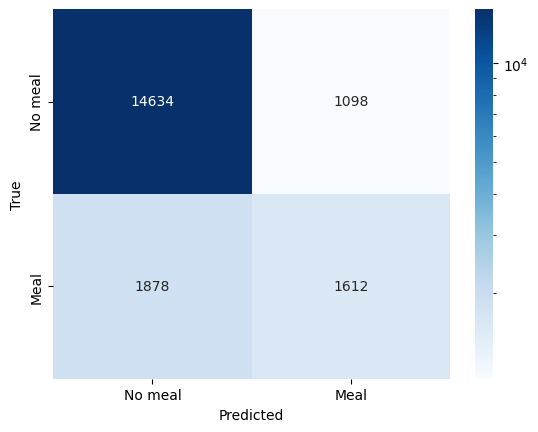

Accuracy:  0.881311816762103
Sensitivity:  0.49570200573065903
Precision:  0.7688888888888888
Specificity:  0.9669211195928753


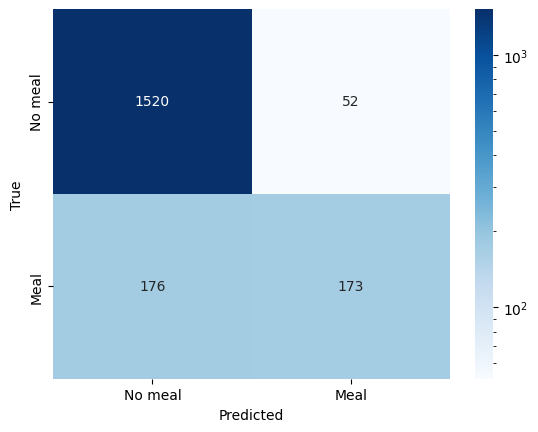

Accuracy:  0.884375
Sensitivity:  0.5172413793103449
Precision:  0.7692307692307693
Specificity:  0.9656488549618321


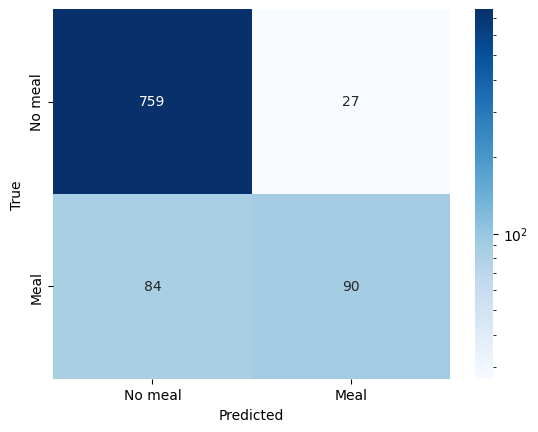

Accuracy:  0.89375
Sensitivity:  0.5517241379310345
Precision:  0.8
Specificity:  0.9694656488549618


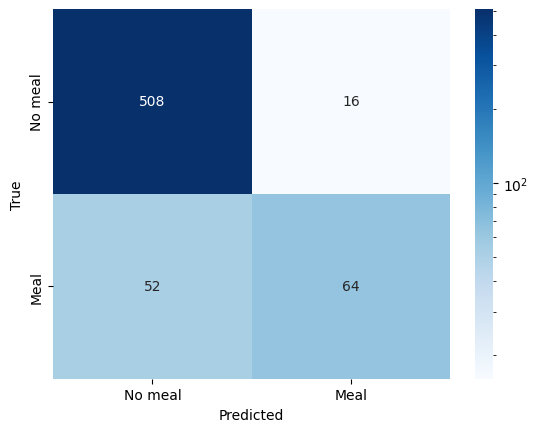

Accuracy:  0.9
Sensitivity:  0.5747126436781609
Precision:  0.819672131147541
Specificity:  0.9720101781170484


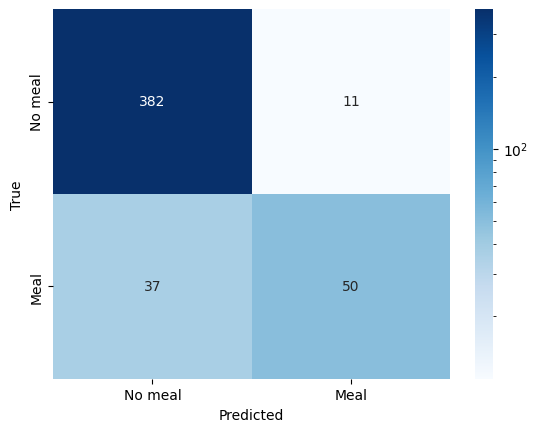

Accuracy:  0.9060052219321149
Sensitivity:  0.5652173913043478
Precision:  0.8666666666666667
Specificity:  0.9808917197452229


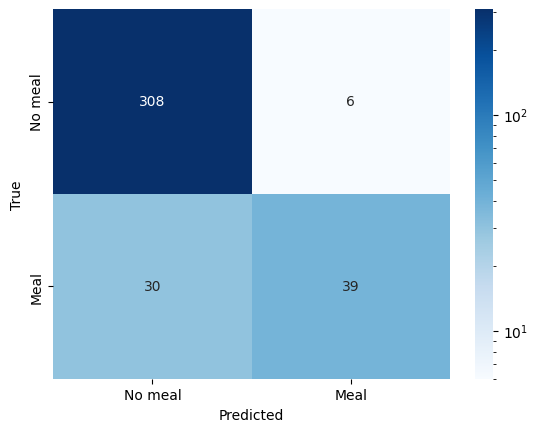

Accuracy:  0.90625
Sensitivity:  0.5689655172413793
Precision:  0.868421052631579
Specificity:  0.9809160305343512


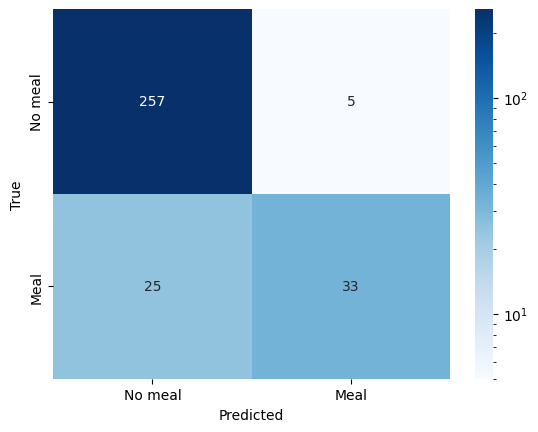

Accuracy:  0.9084249084249084
Sensitivity:  0.58
Precision:  0.8787878787878788
Specificity:  0.9820627802690582


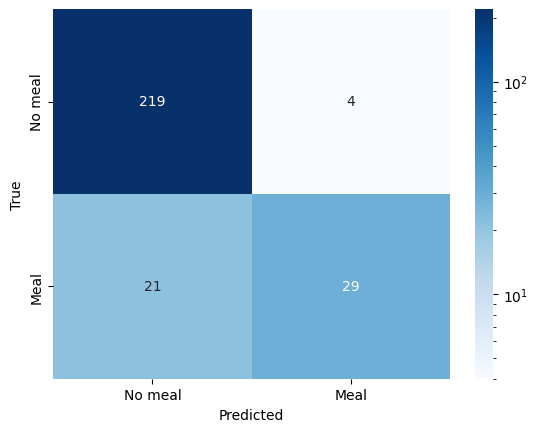

Accuracy:  0.9083333333333333
Sensitivity:  0.5909090909090909
Precision:  0.8666666666666667
Specificity:  0.9795918367346939


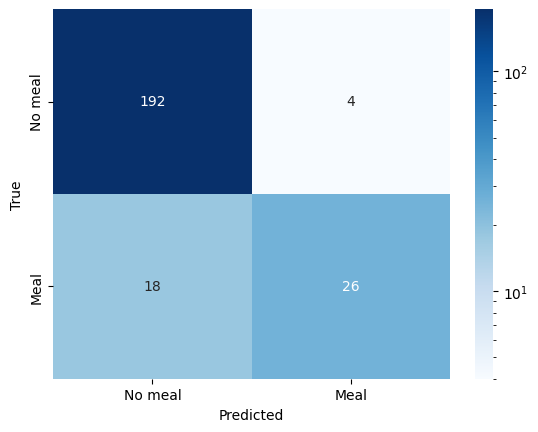

Accuracy:  0.9061032863849765
Sensitivity:  0.5897435897435898
Precision:  0.8518518518518519
Specificity:  0.9770114942528736


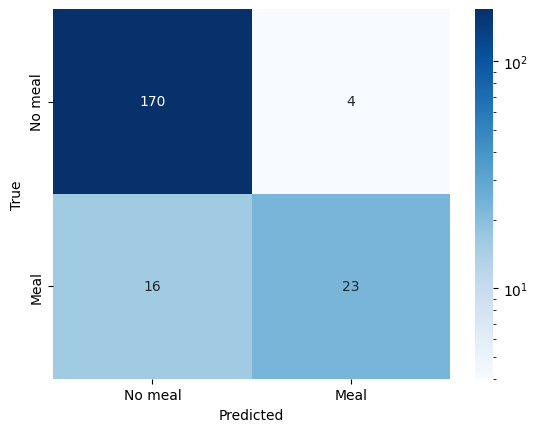

Accuracy:  0.9162303664921466
Sensitivity:  0.6
Precision:  0.9130434782608695
Specificity:  0.9871794871794872


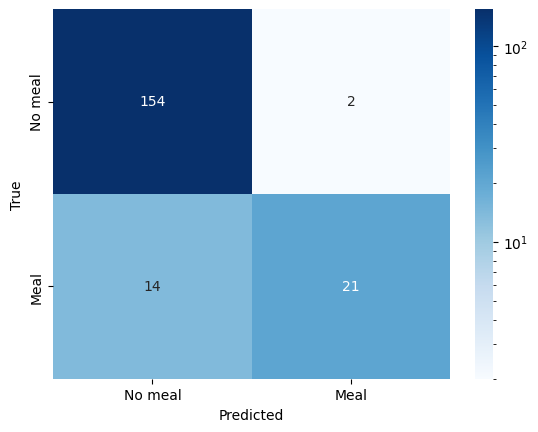

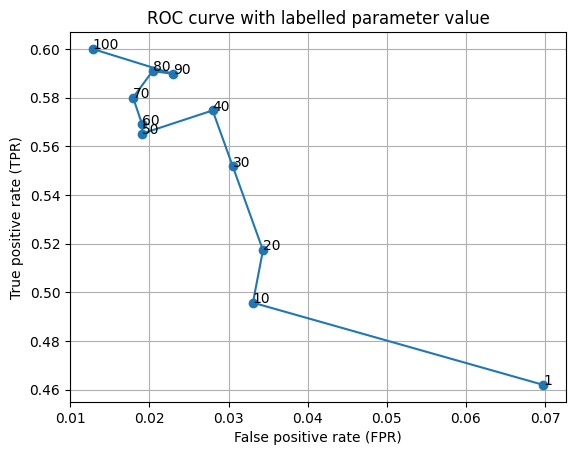

In [10]:
classes = ['No meal','Meal']
test_name = "lda_validation"
extract_test_ROC(test_name)


### Plot evolution of predictions

In [11]:
def calculate_seconds_between_the_subsequences(segment_parameters):
    [segment_length,overlap_length,n_segments] = segment_parameters
    step_length = segment_length - overlap_length
    subsequence_length = n_segments*step_length
    return subsequence_length

In [12]:
def find_meta_data_tsd(id):
    wav_files = []
    metadata_files = []
    recording_ids = []

    # Loop through each academic year in data folder
    root_folder_path_os = os.path.abspath(root_folder_path)
    for year_folder in os.listdir(root_folder_path):
        year_folder_path = os.path.join(root_folder_path,year_folder)
        # Ensure directory (folder)
        if os.path.isdir(year_folder_path): 
            # Loop through each subject in year
            for subject_folder in os.listdir(year_folder_path):
                subject_folder_path = os.path.join(year_folder_path,subject_folder)
                if subject_folder == id:
                    if os.path.isdir(subject_folder_path):
                        metadata_file_path = os.path.join(subject_folder_path, f"{subject_folder}.json")
                        return metadata_file_path
    return None

In [13]:
def find_meta_data(id):
    wav_files = []
    metadata_files = []
    recording_ids = []

    # Loop through each participant in data folder
    root_folder_path_os = os.path.abspath(root_folder_path)
    for subject_folder in os.listdir(root_folder_path_os):
        subject_folder_path = os.path.join(root_folder_path_os,subject_folder)
        # Ensure directory (folder)
        if os.path.isdir(subject_folder_path): 
            # Loop through each recording for subject
            for recording_folder in os.listdir(subject_folder_path):
                recording_folder_path = os.path.join(subject_folder_path,recording_folder)
                if recording_folder == id:
                    if os.path.isdir(recording_folder_path):
                        metadata_file_path = os.path.join(recording_folder_path, f"{recording_folder}.json")
                        return metadata_file_path
    return None

In [14]:
def find_disturbances(id):
    print(id)
    id_file = find_meta_data(id)

    # Extract labels from metadata files
    meta_data = ""
    audio_offset = 0
    with open(id_file, 'r') as file:
        meta_data = json.load(file)
    if "audio_offset" in meta_data:
        audio_offset = meta_data["audio_offset"]
    disturbance_tuples = []
    disturbance_tuples.append((meta_data["mealStart"]-audio_offset,meta_data["mealEnd"]-audio_offset))

    if "disturbances" in meta_data:
        for disturbance in meta_data["disturbances"]:
            disturbance_tuples.append((disturbance["start"]-audio_offset,disturbance["end"]-audio_offset))
    return disturbance_tuples
    

In [15]:
def plot_evolution(true,predictions,disturbances,subsequence_length):
    time = np.linspace(subsequence_length,len(true)*subsequence_length,len(true))
    plt.figure()
    
    for idx, (start, end) in enumerate(disturbances):
        if idx == 0:
            plt.axvspan(start, end, color="b", alpha=0.3)
        else: 
            plt.axvspan(start,end, color="r", alpha=0.3)
    #plt.step(time,true,color='b')
    plt.step(time,predictions,where='post',color='k',linestyle='-',label='Predicted')
    plt.title('Predictions of meal (1) or nonmeal (0) with disturbances')
    plt.xlabel('Time [s]')
    plt.ylabel('Meal or non meal')
    plt.legend()

    detection_time = 999
    (start,end) = disturbances[0]
    for idx, time_instance in enumerate(time):
        if time_instance>end:
            break
        elif time_instance>start:
            if predictions[idx] == 1:
                detection_time = time_instance - start
                break
        
    print('Detection time:',detection_time)


In [16]:
# Segments data into different segments for testing
def segment_labels(data, segment_size):
    segmented = []

    for i in range(len(data)):
        number_subsequences = len(data[i])//segment_size
        subject_segmented = []
        for j in range(0,number_subsequences):
            # Majority voting for the separate segments
            subsequence = round(np.mean(data[i][(j*segment_size):((j+1)*segment_size)]))
            subject_segmented.append(subsequence)
        segmented.append(subject_segmented)
    return segmented


In [17]:
def find_evolution_parameters(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, ids, segment_parameters = [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    print(segment_parameters[0])
    subsequence_length = calculate_seconds_between_the_subsequences(segment_parameters[0])
    for subject_idx in range(len(true)):
        disturbances = find_disturbances(ids[subject_idx])
        plot_evolution(true[subject_idx],predictions[subject_idx],disturbances,subsequence_length)

[1, 0.5, 70]
T6PCJU
Detection time: 999


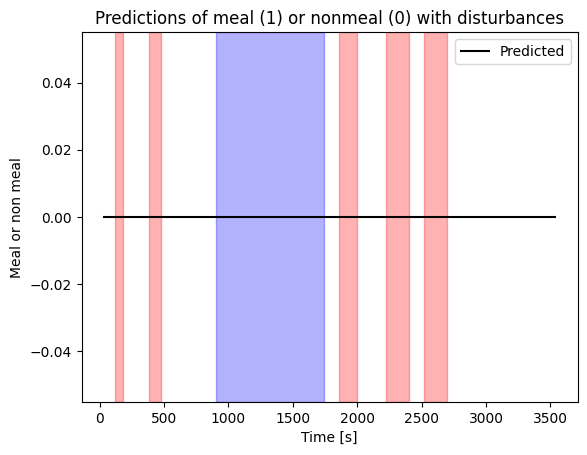

In [ ]:
#folder_path = "hmm_validation\\data\\20250220_105418"
#folder_path = "hmm_test\\data\\20250220_105740"
folder_path = "lda_validation\\data\\20250220_110250"
#folder_path = 
#folder_path = 
find_evolution_parameters(folder_path)